# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# for generating reproducible results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# define function to load train, test, and validation datasets
def load_dataset(path):
    '''
    INPUT:
    path - a directory path to the image
    
    OUTPUT:
    dog_files - a numpy array of dog files
    dog_targets - a numpy array of dog target files
    
    Description:
    load files from a diretory path and return the loaded dog_files and dog_targets files.
    '''
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[35:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


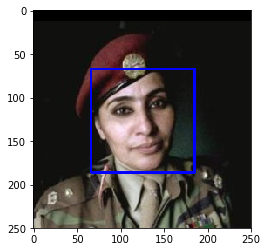

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    len(faces)>0 - a boolean type 
    
    Description:
    load the image from image paths, convert the image to grayscale,
    return "True" if face is detected in image stored at img_path
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- **In the first 100 images of human_files, the percentage of human face detected is 100.00%.**
- **In the first 100 images of dog_files, the percentage of human face detected is 11.00%.**

**OpenCV successfully detected human faces with 100% accuracy, while it mistakenly detected human face in dog files with an error rate of 11%.**

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count_1=0
human_count_2=0
for img in human_files_short:
    if face_detector(img)>0:
        human_count_1 +=1

for i in dog_files_short:
    if face_detector(i)>0:
        human_count_2 +=1

print("In the first 100 images of human_files, the percentage of human face detected is {:.2f}%.".format(human_count_1))
print("In the first 100 images of dog_files, the percentage of human face detected is {:.2f}%.".format(human_count_2))

In the first 100 images of human_files, the percentage of human face detected is 100.00%.
In the first 100 images of dog_files, the percentage of human face detected is 11.00%.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
**In my opinion, it is unrealistic in the real world to capture all the clear face images, as the capture of the human faces can be in an instant moment where the humans, angles or lights are not in the optimum situation. Therefore there are obvious limitations for this algorithm. In order to detect humans in images that does not necessitate an image with a clearly presented face, we might be able to use and optimize CNN.**    

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [8]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
     '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    np.expand_dims(x, axis=0) - a numpy array of 4D tensor 
    
    Description:
    loads RGB image, and convert 3D tensor to 4D tensor, and return 4D tensor
    '''
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
     '''
    INPUT:
    img_paths - url paths to the image
    
    OUTPUT:
    np.vstack(list_of_tensors) - a numpy array of stacked tensors 
    
    Description:
    returns a numpy array of all the stacked tensors
    '''
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    np.argmax(ResNet50_model.predict(img)) - an integer corresponding to the model's predicted object class
    
    Description:
    take the url path to the image as input, take the argmax of the predicted probability vector, 
    and obtain an integer corresponding to the model's predicted object class
    '''
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
     '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    ((prediction <= 268) & (prediction >= 151))  - an boolean type, return True if a dog is detected
    
    Description:
    returns "True" if a dog is detected in the image stored at img_path
    '''
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- **In the images of human_files_short, the percentage of dogs detected is 0.00%**
- **In the images of dog_files_short, the percentage of dogs detected is 100.00%.**

**ResNet-50 has a better accuracy than OpenCV. It gives a 100% detection accuracy in both human_files_short and dog_files_short.**

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_count_1=0
dog_count_2=0
for img in human_files_short:
    if dog_detector(img):
        dog_count_1 +=1

for i in dog_files_short:
    if dog_detector(i):
        dog_count_2 +=1

print("In the images of human_files_short, the percentage of dogs detected is {:.2f}%".format(dog_count_1))
print("In the images of dog_files_short, the percentage of dogs detected is {:.2f}%.".format(dog_count_2))

In the images of human_files_short, the percentage of dogs detected is 0.00%
In the images of dog_files_short, the percentage of dogs detected is 100.00%.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 87.92it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

**Generally, the convolutional layers:**
- **divide the orginal image information into several small pieces of feature maps, and then try to identify the patterns from the small pieces of feature maps. Every piece will share the same weights, which greatly reduces the parameters the algorithm deal with. Meanwhile, the convoluational layers stack the small pieces of feature maps in differet planes, which increases the depth of all the features and ensures that all information is kept intact without losing.** 

- **and thus has the following advantages: 1)greatly reduces the parameters of computation, 2)boosts the computational speed 3)prevent overfitting.**

**On the other hand, the pooling layers would take the average or the maximum of the features on each small piece, which greatly decrease the dimensionality and compuational parameters and in turn boost the computation speed.**

**Generally, when we build the architecture, after one or two convolutaional layers, one pooling layer is normally used to reduce the dimensionality. This rule of thumb has already been widely verified in improving prediction accurary and reducing computation time.** 

**Based on the advised architecure above, I used the following similar architecure. There are totally 8 layers.**
- the 1st layer is a convolutional layer. The number of filters is the same with the number of small pieces of feature maps. Kernel size by default is 2\*2; stride by default is 1. To prevent the information from losing, I used fill with zero on 'padding'. The input shape is based on the dimension of input tensors.
- the 2nd layer is a maximum pooling layer, which is used to decrease the dimensionality.
- the 3rd layer is a convolutional layer.
- the 4th layer is a maximum pooling layer.
- the 5th layer is a covolutional layer.
- the 6th layer is a maximum pooling layer.
- the 7th layer is GAP (Global Average Pooling) layer.It take the average of all the features on each feature map. This reduces the dimensions greatly by converting the feature maps into a feature vector.
- the 8th layer is a dense layer. The input nodes will be the total classes of all the dogs, which in our case is 133. By default a softmax activation function is used.

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))                 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 12

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/12
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8825 - acc: 0.0081 - val_loss: 4.8650 - val_acc: 0.0108
Epoch 2/12
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8519 - acc: 0.0130 - val_loss: 4.8308 - val_acc: 0.0168
Epoch 3/12
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8070 - acc: 0.0160 - val_loss: 4.8084 - val_acc: 0.0192
Epoch 4/12
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7805 - acc: 0.0183 - val_loss: 4.7976 - val_acc: 0.0180
Epoch 5/12
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7549 - acc: 0.0199 - val_loss: 4.7641 - val_acc: 0.0204
Epoch 6/12
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7314 - acc: 0.0263 - val_loss: 4.7529 - val_acc: 0.0263
Epoch 7/12
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7063 - acc: 0.0265 - val_loss: 4.7269 - val_acc: 0.0216
Epoch 8/

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.1866%


**This CNN model from scratch gives an accuracy of 4.1866% in 10 epochs.**

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [20]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 310us/step - loss: 12.2832 - acc: 0.1190 - val_loss: 10.8387 - val_acc: 0.2048
Epoch 2/20
6680/6680 [==============================] - 2s 260us/step - loss: 10.1294 - acc: 0.2778 - val_loss: 10.1913 - val_acc: 0.2922
Epoch 3/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.6903 - acc: 0.3409 - val_loss: 9.8555 - val_acc: 0.3114
Epoch 4/20
6680/6680 [==============================] - 2s 244us/step - loss: 9.3951 - acc: 0.3678 - val_loss: 9.6439 - val_acc: 0.3341
Epoch 5/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.2378 - acc: 0.3943 - val_loss: 9.6027 - val_acc: 0.3401
Epoch 6/20
6680/6680 [==============================] - 2s 243us/step - loss: 9.1794 - acc: 0.4054 - val_loss: 9.6708 - val_acc: 0.3389
Epoch 7/20
6680/6680 [==============================] - 2s 245us/step - loss: 9.0482 - acc: 0.4115 - val_loss: 9.3399 - val_acc: 0.34

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.4641%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    dog_names[np.argmax(predicted_vector)] - strings of predicted dog names 
    
    Description:
    extract bottleneck features from the image path, obtain the predicted vector,
    and return dog breed that is predicted by the model
    '''
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

**The brief introduction for the abovementioned models in the [Keras documentation](https://keras.io/applications/), I find that the default input size for VGG16, VGG19, ResNet-50 is 224\*224, while the input size for InceptionV3, or Xception is 229\*299. It seems that InceptionV3 and Xception are preprocessed and thus the input size is compatible to our model.**

**In this project, I will run on the four models and compare their performances.**

In [27]:
### TODO: Obtain bottleneck features from VGG-19.
bottleneck_features_1 = np.load('/data/bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features_1['train']
valid_VGG19 = bottleneck_features_1['valid']
test_VGG19 = bottleneck_features_1['test']

In [28]:
### TODO: Obtain bottleneck features from ResNet-50.
bottleneck_features_2 = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features_2['train']
valid_ResNet50 = bottleneck_features_2['valid']
test_ResNet50 = bottleneck_features_2['test']

In [29]:
### TODO: Obtain bottleneck features from InceptionV3.
bottleneck_features_3 = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features_3['train']
valid_Inception = bottleneck_features_3['valid']
test_Inception = bottleneck_features_3['test']

In [30]:
### TODO: Obtain bottleneck features from Xception.
bottleneck_features_4 = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features_4['train']
valid_Xception = bottleneck_features_4['valid']
test_Xception = bottleneck_features_4['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

1. **first of all, the pre-computed model(VGG19, ResNet-50, InceptionV3, Xception) is seleted. The bottleneck features from the pre-trained model are all extracted and stored in bottleneck_features. This pre-trained model output which is going to be my own input layer. All the features from the pre-trained model output are called as bottleneck features. Therefore this step is to have the input of our model (basically the last few layers) ready.**
2. **With the bottleneck feature as the input of our model, now we construct our CNN architecture on top of the pre-trained model. In this way we only need to add last few layers. In this project, we add a GAP layer and a dense layer. The GAP layer is used to reduce the dimensions. The dense layer will use softmax as the activation function, with a 133 corresponding to the number of dog breeds.**


In [31]:
### TODO: Define your architecture using VGG19
from keras.applications.vgg19 import VGG19

VGG19_model_transfer = Sequential()
VGG19_model_transfer.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model_transfer.add(Dense(133, activation='softmax'))

VGG19_model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [32]:
### TODO: Define your architecture uxing ResNet50
from keras.applications.resnet50 import ResNet50

ResNet50_model_transfer = Sequential()
ResNet50_model_transfer.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model_transfer.add(Dense(133, activation='softmax'))

ResNet50_model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [33]:
### TODO: Define your architecture using InceptionV3
from keras.applications import InceptionV3

Inception_model_transfer = Sequential()
Inception_model_transfer.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inception_model_transfer.add(Dense(133, activation='softmax'))

Inception_model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [34]:
### TODO: Define your architecture using Xception
from keras.applications import Xception

Xception_model_transfer = Sequential()
Xception_model_transfer.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_transfer.add(Dense(133, activation='softmax'))

Xception_model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Save the model for model optimization later
Xception_model_transfer_1 = Xception_model_transfer
Xception_model_transfer_2 = Xception_model_transfer

### (IMPLEMENTATION) Compile the Model

In [36]:
### TODO: Compile the model using VGG19
VGG19_model_transfer.compile(loss='categorical_crossentropy', 
                             optimizer='rmsprop', 
                             metrics=['accuracy'])

In [37]:
### TODO: Compile the model using ResNet50
ResNet50_model_transfer.compile(loss='categorical_crossentropy', 
                             optimizer='rmsprop', 
                             metrics=['accuracy'])

In [38]:
### TODO: Compile the model using InceptionV3
Inception_model_transfer.compile(loss='categorical_crossentropy', 
                             optimizer='rmsprop', 
                             metrics=['accuracy'])

In [39]:
### TODO: Compile the model using Xception
Xception_model_transfer.compile(loss='categorical_crossentropy', 
                             optimizer='rmsprop', 
                             metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [40]:
### TODO: Train the model using VGG19.
earlystopping = EarlyStopping(monitor='val_loss', patience=2) # Early stop the fitting if the loss doesn't improve anymore
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model_transfer.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 327us/step - loss: 12.2042 - acc: 0.1150 - val_loss: 10.7083 - val_acc: 0.2084
Epoch 2/20
6680/6680 [==============================] - 2s 257us/step - loss: 10.0374 - acc: 0.2900 - val_loss: 9.9425 - val_acc: 0.2874
Epoch 3/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.6068 - acc: 0.3497 - val_loss: 9.7038 - val_acc: 0.3186
Epoch 4/20
6680/6680 [==============================] - 2s 247us/step - loss: 9.3345 - acc: 0.3801 - val_loss: 9.5542 - val_acc: 0.3401
Epoch 5/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.1845 - acc: 0.4001 - val_loss: 9.5309 - val_acc: 0.3341
Epoch 6/20
6680/6680 [==============================] - 2s 245us/step - loss: 9.1164 - acc: 0.4124 - val_loss: 9.5223 - val_acc: 0.3389
Epoch 7/20
6680/6680 [==============================] - 2s 246us/step - loss: 8.9706 - acc: 0.4220 - val_loss: 9.3561 - val_acc: 0.353

In [41]:
### TODO: Train the model using ResNet50.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model_transfer.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 269us/step - loss: 1.6034 - acc: 0.6093 - val_loss: 0.8146 - val_acc: 0.7473
Epoch 2/20
6680/6680 [==============================] - 1s 220us/step - loss: 0.4356 - acc: 0.8638 - val_loss: 0.7302 - val_acc: 0.7725
Epoch 3/20
6680/6680 [==============================] - 1s 221us/step - loss: 0.2607 - acc: 0.9202 - val_loss: 0.6669 - val_acc: 0.8000
Epoch 4/20
6680/6680 [==============================] - 1s 218us/step - loss: 0.1655 - acc: 0.9490 - val_loss: 0.7359 - val_acc: 0.7916
Epoch 5/20
6680/6680 [==============================] - 1s 218us/step - loss: 0.1249 - acc: 0.9599 - val_loss: 0.6744 - val_acc: 0.8240


In [42]:
### TODO: Train the model using Inception.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model_transfer.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 367us/step - loss: 1.1573 - acc: 0.7091 - val_loss: 0.7000 - val_acc: 0.8048
Epoch 2/20
6680/6680 [==============================] - 2s 314us/step - loss: 0.4682 - acc: 0.8618 - val_loss: 0.6459 - val_acc: 0.8275
Epoch 3/20
6680/6680 [==============================] - 2s 312us/step - loss: 0.3703 - acc: 0.8853 - val_loss: 0.6313 - val_acc: 0.8455
Epoch 4/20
6680/6680 [==============================] - 2s 310us/step - loss: 0.2854 - acc: 0.9112 - val_loss: 0.7620 - val_acc: 0.8263
Epoch 5/20
6680/6680 [==============================] - 2s 311us/step - loss: 0.2408 - acc: 0.9240 - val_loss: 0.7277 - val_acc: 0.8395


In [43]:
### TODO: Train the model using Xception.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 470us/step - loss: 1.0540 - acc: 0.7361 - val_loss: 0.5246 - val_acc: 0.8132
Epoch 2/20
6680/6680 [==============================] - 3s 401us/step - loss: 0.4043 - acc: 0.8743 - val_loss: 0.4686 - val_acc: 0.8431
Epoch 3/20
6680/6680 [==============================] - 3s 401us/step - loss: 0.3254 - acc: 0.8988 - val_loss: 0.4755 - val_acc: 0.8479
Epoch 4/20
6680/6680 [==============================] - 3s 401us/step - loss: 0.2812 - acc: 0.9118 - val_loss: 0.4986 - val_acc: 0.8587


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [44]:
### TODO: Load the model weights with the best validation loss.
VGG19_model_transfer.load_weights('saved_models/weights.best.VGG19.hdf5')
ResNet50_model_transfer.load_weights('saved_models/weights.best.ResNet50.hdf5')
Inception_model_transfer.load_weights('saved_models/weights.best.Inception.hdf5')
Xception_model_transfer.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [45]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]
ResNet50_predictions = [np.argmax(ResNet50_model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]
Inception_predictions = [np.argmax(Inception_model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]
Xception_predictions = [np.argmax(Xception_model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy_1 = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
test_accuracy_2 = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
test_accuracy_3 = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
test_accuracy_4 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)


print('Test accuracy using VGG19: %.4f%%' % test_accuracy_1)
print('Test accuracy using ResNet50: %.4f%%' % test_accuracy_2)
print('Test accuracy using Inception: %.4f%%' % test_accuracy_3)
print('Test accuracy using Xception: %.4f%%' % test_accuracy_4)

Test accuracy using VGG19: 37.4402%
Test accuracy using ResNet50: 80.1435%
Test accuracy using Inception: 80.9809%
Test accuracy using Xception: 84.2105%


**The accuracy of ResNet50, Inception, Xception are all above 80%. Xception outperforms the rest models with an accuracy of 84.2105%.**

**In order to further enhance the performance of Xception model, I will try to optimize the parameters.**

**Regarding the loss function available in [Keras](https://keras.io/losses/), the categorical_crossentropy applies to categorical multiclass classification, and thus applies well to our case. Hence I will keep it.**

**With respect to the optimizer, [This reference](http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent) mentions that RMSprop, Adadelta, and Adam are very similar algorithms (adaptive learning-rate methods) that do well in similar circumstances. Adam slightly outperforms RMSprop towards the end of optimization as gradients become sparser. Insofar, Adam might be the best overall choice. Besides, [this references](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) also echoes. Therefore, I will use Adam as the alternative optimizer.**

**In addition, [This reference](http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent) above also mentions that Nadam (Nesterov-accelerated Adaptive Moment Estimation) combines Adam and Nesterov accelerated gradient (NAG). Therefore I will use Nadam as the optimizer as well.**

**I will start with Xception with Adam.**

In [46]:
### TODO: Compile the model using Xception, change the optimizer into Adam
Xception_model_transfer_1.compile(loss='categorical_crossentropy', 
                             optimizer='Adam', 
                             metrics=['accuracy'])

In [47]:
### TODO: Train the model using Xception again.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_1.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 513us/step - loss: 0.3549 - acc: 0.8886 - val_loss: 0.5357 - val_acc: 0.8240
Epoch 2/20
6680/6680 [==============================] - 3s 427us/step - loss: 0.2094 - acc: 0.9311 - val_loss: 0.4922 - val_acc: 0.8467
Epoch 3/20
6680/6680 [==============================] - 3s 422us/step - loss: 0.1417 - acc: 0.9557 - val_loss: 0.4914 - val_acc: 0.8563
Epoch 4/20
6680/6680 [==============================] - 3s 436us/step - loss: 0.0927 - acc: 0.9768 - val_loss: 0.5099 - val_acc: 0.8443
Epoch 5/20
6680/6680 [==============================] - 3s 431us/step - loss: 0.0706 - acc: 0.9834 - val_loss: 0.5047 - val_acc: 0.8503


In [48]:
### TODO: Load the model weights with Adam with the best validation loss.
Xception_model_transfer_1.load_weights('saved_models/weights.best.Xception.hdf5')

In [49]:
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model_transfer_1.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_5 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with Adam: %.4f%%' % test_accuracy_5)

Test accuracy using Xception with Adam: 85.6459%


**Then here comes Xception with Nadam.**

In [50]:
### TODO: Compile the model using Xception, change the optimizer into Nadam
Xception_model_transfer_2.compile(loss='categorical_crossentropy', 
                             optimizer='Nadam', 
                             metrics=['accuracy'])
### TODO: Train the model using Xception again.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_2.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 521us/step - loss: 0.2020 - acc: 0.9323 - val_loss: 0.6883 - val_acc: 0.8192
Epoch 2/20
6680/6680 [==============================] - 3s 443us/step - loss: 0.1065 - acc: 0.9627 - val_loss: 0.6387 - val_acc: 0.8383
Epoch 3/20
6680/6680 [==============================] - 3s 439us/step - loss: 0.0659 - acc: 0.9808 - val_loss: 0.5699 - val_acc: 0.8527
Epoch 4/20
6680/6680 [==============================] - 3s 434us/step - loss: 0.0403 - acc: 0.9888 - val_loss: 0.6402 - val_acc: 0.8491
Epoch 5/20
6680/6680 [==============================] - 3s 431us/step - loss: 0.0293 - acc: 0.9936 - val_loss: 0.6395 - val_acc: 0.8407


In [51]:
### TODO: Load the model weights with the best validation loss.
Xception_model_transfer_2.load_weights('saved_models/weights.best.Xception.hdf5')

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model_transfer_2.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_6 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with Nadam: %.4f%%' % test_accuracy_6)

Test accuracy using Xception with Nadam: 84.9282%


In [52]:
# show the accuracy for the pre-train models in this project
print('Test accuracy using VGG16: %.4f%%' % test_accuracy)
print('Test accuracy using VGG19: %.4f%%' % test_accuracy_1)
print('Test accuracy using ResNet50: %.4f%%' % test_accuracy_2)
print('Test accuracy using Inception: %.4f%%' % test_accuracy_3)
print('Test accuracy using Xception: %.4f%%' % test_accuracy_4)
print('Test accuracy using Xception with Adam: %.4f%%' % test_accuracy_5)
print('Test accuracy using Xception with Nadam: %.4f%%' % test_accuracy_6)

Test accuracy using VGG16: 42.4641%
Test accuracy using VGG19: 37.4402%
Test accuracy using ResNet50: 80.1435%
Test accuracy using Inception: 80.9809%
Test accuracy using Xception: 84.2105%
Test accuracy using Xception with Adam: 85.6459%
Test accuracy using Xception with Nadam: 84.9282%


**The accuracy of Xception is enhanced by using Adam as the optimizer, from 84.2105% to 85.6459%. Xception with Nadam as the optimizer gives an accuracy of 84.9282%. Xception with Adam model turns out to be the optimum model, hence I will use this model for the dog breed prediction in next step.**

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [53]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model - Xception with Adam as the optimum.

from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    dog_names[np.argmax(dog_breed_predicted)] - strings of predicted dog names 
    
    Description:
    extract bottleneck features from the image path, use the selected model to obtain the predicted vector,
    and return dog breed that is predicted by the model
    '''
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    dog_breed_predicted = Xception_model_transfer_1.predict(bottleneck_feature) #Xception_model_transfer_1 is used here
    return dog_names[np.argmax(dog_breed_predicted)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [54]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

#if dog is detected,then return True,otherwise False
def dog_detector(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    ((prediction <= 268) & (prediction >= 151))  - an boolean type, return True if a dog is detected
    
    Description:
    return "True" if a dog is detected in the image stored at img_path
    '''
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

# if a human face is detected in img_path, return True
def face_detector(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    len(faces)>0 - a boolean type 
    
    Description:
    load the image from image paths, convert the image to grayscale,
    return "True" if face is detected in image stored at img_path
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


def predict_breed(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    if a dog is detected, print"Hello, dogs" and the predicted dog breed, and the image is shown
    if a human is detected, print"Hello, humans" and the predicted dog breed they resemble most, and the image is shown
    if neither a dog nor a human is detected, print"You are neither dogs nor humans.", the image is shown

    Description:
    if a dog is detected, print"Hello, dogs" and the predicted dog breed;
    if a human is detected, print"Hello, humans" and the predicted dog breed they resemble most
    if neither a dog nor a human is detected, print"You are neither dogs nor humans."
    The images we predicted on are shown meanwhile
    '''
    if dog_detector(img_path):
        print("Hello, dogs!")
        breed = Xception_predict_breed(img_path)
        print("You are a {}.".format(breed))
    
    elif face_detector(img_path):        
        print("Hello, humans!")
        breed = Xception_predict_breed(img_path)
        print("If you were a dog, you are a {}.".format(breed))
    
    else:
        print("You are neither dogs nor humans.")
    
    #image processing    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    plt.imshow(cv_rgb)
    plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

**1. Based on the prediction results, the model gives a better prediction accuracy on human faces or neither, while it made mistakes in predicting dogs. However the overall accuracy is high and therefore acceptable. The results are better than my expectation.**

**2. There are several proposals to further improve my model:**
- **In transfer learning, other than the pre-trained models compared in this project, other models can also be used, such as InceptionResNetV2, MobileNet, DenseNet listed on [Keras documentation](https://keras.io/applications).**
- **When constructing the last few layers for transfer learning, other layers can also be used, such as Dropout layers. An agressive Dropout layer has been proven to prevent overfitting and increase accuracy.** 
- **Data Agumentation can also be considered to further improve the model. By using data agumentation, more relevant features will be trained and strengthened, while the less relevant patterns will be weakened. This can enhance the overall performance, and overfitting will also be prevented. The robustness of the model would be boosted as well. This has been proved by [experiments](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b).**
- **Fine-tuning on the model parameters and hyperparameters, such as learning rates, vanilla SGD without momentum as mentioned [here](http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent).** 

Hello, dogs!
You are a Maltese.


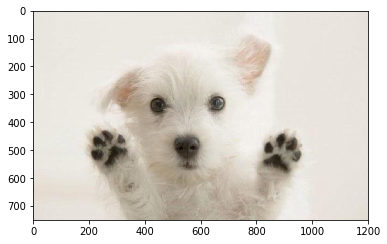

In [56]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
predict_breed('images/1.jpeg')

Hello, dogs!
You are a Pomeranian.


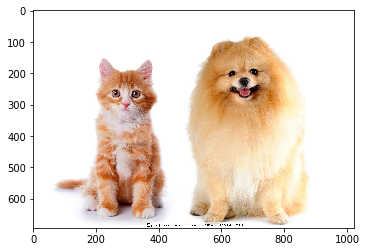

In [57]:
predict_breed('images/2.jpg')

You are neither dogs nor humans.


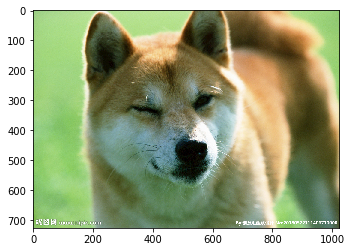

In [58]:
predict_breed('images/3.jpg')

Hello, dogs!
You are a Kuvasz.


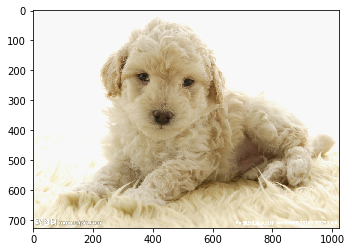

In [59]:
predict_breed('images/5.jpg')

You are neither dogs nor humans.


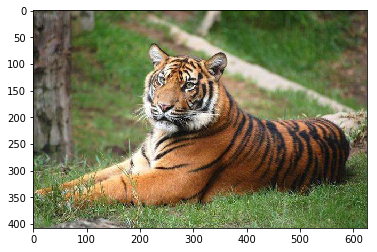

In [60]:
predict_breed('images/6.jpg')

You are neither dogs nor humans.


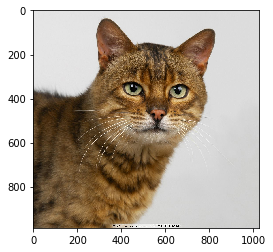

In [61]:
predict_breed('images/7.jpg')

Hello, dogs!
You are a Dalmatian.


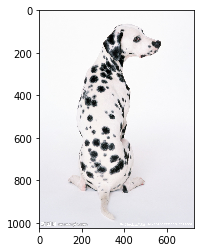

In [62]:
predict_breed('images/8.jpg')

Hello, dogs!
You are a American_eskimo_dog.


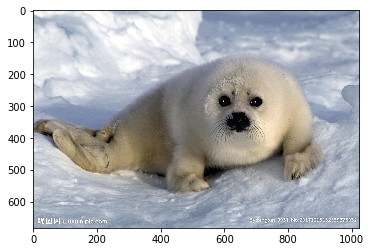

In [63]:
predict_breed('images/9.jpg')

Hello, dogs!
You are a Chihuahua.


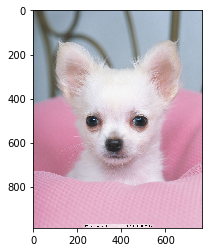

In [64]:
predict_breed('images/10.jpg')

You are neither dogs nor humans.


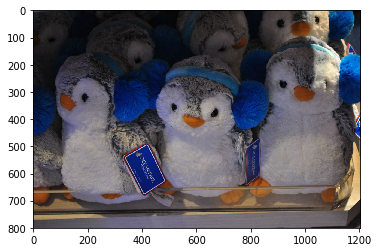

In [65]:
predict_breed('images/12.jpg')

Hello, humans!
If you were a dog, you are a Anatolian_shepherd_dog.


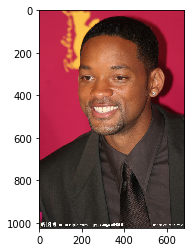

In [67]:
predict_breed('images/14.jpg')

Hello, humans!
If you were a dog, you are a Cane_corso.


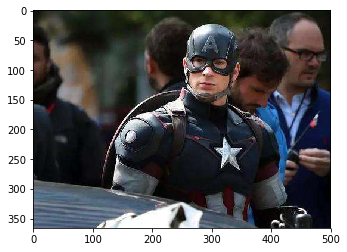

In [68]:
predict_breed('images/15.jpg')

Hello, humans!
If you were a dog, you are a Cardigan_welsh_corgi.


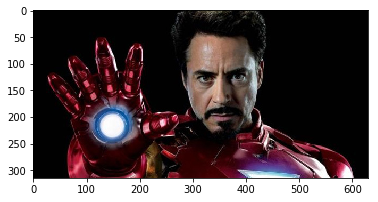

In [69]:
predict_breed('images/16.jpg')

## References

https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

https://stackoverflow.com/questions/43906048/keras-early-stopping

http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent

https://keras.io/callbacks/#earlystopping

https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

